In [1]:
# http://sgjp.pl/morfeusz/dopobrania.html.en
# https://bulldogjob.pl/news/650-przeglad-pakietu-datatable-pythona
# http://dsmodels.nlp.ipipan.waw.pl/

In [2]:
selected_labels = ['rage_cat']
# ['rage_cat', 'joy_cat', 'surprise_cat', 'fear_cat', 'sadness_cat']
selected_features = ['title', 'highlight']
# ['title', 'media_desc', 'highlight', 'division', 'content']
normalize_emotion_label = 'multiply'
# 'cut', 'multiply', None, 'weights'
input_articles = 'lemmatized_articles.csv' 
# lemmatized_articles.csv
word2vec = 300

In [3]:
import pandas as pd
from unidecode import unidecode
from collections import Counter
import numpy as np

In [4]:
articles = pd.read_csv('data/'+input_articles, nrows = 20000)

In [5]:
articles.head(1)

,content,division,highlight,media_desc,title,url
0,najwyzsza izba kontrola zwracac uwage problem ...,zus emerytura,tysiace polakow zanizone emerytura wystapilo z...,osoba maja dopisac skladek emerytalny czas stu...,nik alarmowac polak maja zanizone emerytura,"http://wyborcza.biz/biznes/7,147880,23632593,n..."


In [6]:
len(articles)

19087

In [7]:
articles = articles.dropna()

In [8]:
len(articles)

19056

## Prepare input for model

In [9]:
def concat_x_string(columns):
    a = pd.Series('', index = articles.index)
    for column in columns:
        a = a + articles[column] + ' '
    return a.str.strip().str.split(' ').values

In [10]:
string_columns = concat_x_string(selected_features)

In [11]:
string_columns[1][:10]

['katalonia',
 'premiera',
 'parlament',
 'barcelona',
 'przeglosowal',
 'kandydature',
 'secesjonista',
 'quima',
 'torry',
 'nowy']

In [12]:
with open('../polish_word2vec_'+str(word2vec)) as f:
    word2vec_file = f.read().split('\n')

In [13]:
word2vec_dict = {
    word2vec_file_line.split(' ')[0]:
    [float(x) for x in word2vec_file_line.split(' ')[1:]]
for word2vec_file_line in word2vec_file}

In [14]:
def get_record_vector(record, vocabulary, word2vec_dict):
    feature_vector = np.zeros(word2vec,dtype="float64")
    nwords = 0
    
    for word in record:
        if word in vocabulary: 
            feature_vector = np.add(feature_vector, word2vec_dict[word])
            nwords += 1
    
    if nwords:
        feature_vector = np.divide(feature_vector, nwords)
        
    return feature_vector

In [15]:
vocabulary = word2vec_dict.keys()

In [16]:
word2vec_columns = [get_record_vector(string_column, vocabulary, word2vec_dict) for string_column in string_columns]

In [17]:
x = np.array(word2vec_columns)

## Prepare labels

In [18]:
from labeling.emotions import rage, joy, sadness, surprise, fear, all_flag_words

In [19]:
comments_raw = pd.concat([
    pd.read_csv('data/processed_comments_1.csv'),
    pd.read_csv('data/processed_comments_2.csv')
])[['url', 'downvotes', 'upvotes', 'words']]

In [20]:
comments_raw.head(1)

,url,downvotes,upvotes,words
0,"http://wyborcza.biz/biznes/7,147880,23632593,n...",0,10,"['brak', 'kwartalnych', 'waloryzacji', 'kapita..."


In [21]:
comment_emotions = []
for comment in comments_raw['words'].values:
    record_labels = [0, 0, 0, 0, 0, 0]
    eval_comment = eval(comment)
    
    for i, emotion in enumerate([rage, joy, sadness, surprise, fear]):
        for flag_word in emotion:
            if flag_word in eval_comment:
                record_labels[i] += 1
        if record_labels[i] != 0:
            record_labels[5] += 1
                
    comment_emotions.append(record_labels)

In [22]:
emotions_df = pd.DataFrame(comment_emotions, index = comments_raw.index)
emotions_df.columns = ['rage', 'joy', 'sadness', 'surprise', 'fear', 'emotions_count']

In [23]:
comments = pd.concat([comments_raw, emotions_df], axis = 1).drop('words', axis = 1)

In [24]:
comments[comments['url'] == 'http://bialystok.wyborcza.pl/bialystok/7,35241,23042200,komorowski-budowanie-dumy-z-polskiej-historii-konczy-sie-wstydem.html']

,url,downvotes,upvotes,rage,joy,sadness,surprise,fear,emotions_count
221003,"http://bialystok.wyborcza.pl/bialystok/7,35241...",2,14,0,0,0,0,0,0
221004,"http://bialystok.wyborcza.pl/bialystok/7,35241...",9,6,0,0,0,0,0,0
221005,"http://bialystok.wyborcza.pl/bialystok/7,35241...",8,1,0,0,0,0,0,0
221006,"http://bialystok.wyborcza.pl/bialystok/7,35241...",1,4,0,0,0,0,0,0


In [25]:
sums = comments\
    .groupby('url')\
    .sum()

In [26]:
counts = comments\
    [['url', 'downvotes']]\
    .groupby('url')\
    .count()
counts.columns = ['replies']

In [27]:
labels = pd.concat([counts, sums], axis = 1)\
    .reindex(articles['url'])\
    .reset_index()\
    .drop('url', axis = 1)

In [28]:
labels['reactions'] = labels['upvotes'] + labels['downvotes']

In [29]:
len(labels)

19056

In [30]:
labels.head(1)

,replies,downvotes,upvotes,rage,joy,sadness,surprise,fear,emotions_count,reactions
0,2.0,0.0,11.0,0.0,0.0,0.0,0.0,0.0,0.0,11.0


In [31]:
# Remove extreme values
labels.loc[labels['replies'] > 200, 'replies'] = 200
labels.loc[labels['downvotes'] > 500, 'downvotes'] = 500
labels.loc[labels['upvotes'] > 4000, 'upvotes'] = 4000
labels.loc[labels['reactions'] > 4500, 'reactions'] = 4500

In [32]:
# Add categorized labels
labels.loc[labels['replies'] < 7, 'replies_cat'] = -1
labels.loc[(labels['replies'] <= 25)&(labels['replies'] >= 7), 'replies_cat'] = 0
labels.loc[labels['replies'] > 25, 'replies_cat'] = 1

labels.loc[labels['reactions'] < 30, 'reactions_cat'] = -1
labels.loc[(labels['reactions'] <= 200)&(labels['reactions'] >= 30), 'reactions_cat'] = 0
labels.loc[labels['reactions'] > 200, 'reactions_cat'] = 1

means_for_balance = []
for emotion in ['rage', 'joy', 'sadness', 'surprise', 'fear']:
    labels.loc[labels[emotion] > 0 , emotion+'_cat'] = 1
    labels.loc[labels[emotion] == 0, emotion+'_cat'] = -1
    means_for_balance.append(len(labels[labels[emotion] != 1])/len(labels[labels[emotion] == 1]))

In [33]:
# labels[(labels['rage']!=0)&
#        (labels['joy']!=0)&
#        (labels['sadness']!=0)&
#        (labels['surprise']!=0)&
#        (labels['fear']!=0)]

In [34]:
# labels\
#     .groupby('fear_cat')\
#     .count()\
#     .plot(kind = 'bar')

In [35]:
less_class_count = len(labels[labels[selected_labels[0]] == 1])
labels_train = labels[labels[selected_labels[0]] == 1].iloc[:int(0.9*less_class_count)]
labels_test = labels[labels[selected_labels[0]] == 1].iloc[int(0.9*less_class_count):]

In [36]:
b = int(len(labels) * 0.9)

In [37]:
#if selected_labels[0] in ['rage_cat', 'joy_cat', 'surprise_cat', 'fear_cat', 'sadness_cat']:
if normalize_emotion_label == 'cut':
    l = len(labels[labels[selected_labels[0]] == 1])
    labels = pd.concat([
        labels[labels[selected_labels[0]] == 1],
        labels[labels[selected_labels[0]] == -1].iloc[:l]
    ])
elif normalize_emotion_label == 'multiply':
    m = int(len(labels[labels[selected_labels[0]] == -1])/len(labels_train))
    labels_norm = pd.concat([
        labels_train for x in range(m)
    ] + [labels[labels[selected_labels[0]] == -1]])
else:
    labels_norm = labels.iloc[:b]
    labels_test = labels.iloc[b:]

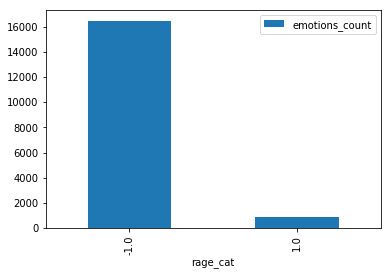

In [38]:
labels\
    .groupby(selected_labels[0])\
    .count()\
    [['emotions_count']]\
    .plot(kind = 'bar')

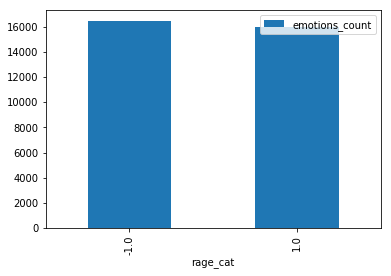

In [39]:
labels_norm\
    .groupby(selected_labels[0])\
    .count()\
    [['emotions_count']]\
    .plot(kind = 'bar')

## Merge x and y

In [40]:
labels_norm = labels_norm.sample(frac=1)
labels_test = labels_test.sample(frac=1)

In [41]:
labels_indices_train = labels_norm[labels_norm['reactions'].isna() == False].index.values
labels_indices_test = labels_test[labels_test['reactions'].isna() == False].index.values

In [42]:
labels_train = labels_norm[labels_norm['reactions'].isna() == False]

In [43]:
train_x = x[labels_indices_train]
train_y = labels_norm[labels_norm['reactions'].isna() == False][selected_labels[0]].values

test_x = x[labels_indices_test]
test_y = labels_test[labels_test['reactions'].isna() == False][selected_labels[0]].values

In [44]:
print(train_x.shape, train_y.shape)

(32462, 300) (32462,)


In [45]:
print(test_x.shape, test_y.shape)

(85, 300) (85,)


## Training

In [46]:
from tensorflow.keras import Sequential, Model, Input
from tensorflow.keras.layers import Dense
from tensorflow.nn import relu

In [47]:
inputs = Input(shape = (word2vec, ))

In [48]:
hidden_1 = Dense(80, activation = relu)(inputs)
hidden_2 = Dense(20, activation = relu)(hidden_1)

W0628 19:13:12.585921 140276295833344 deprecation.py:506] From /usr/local/lib/python3.5/dist-packages/tensorflow/python/ops/init_ops.py:1251: calling VarianceScaling.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


In [49]:
outputs = Dense(len(selected_labels))(hidden_2)

In [50]:
model = Model(
    inputs = inputs,
    outputs = outputs
)

In [51]:
from tensorflow.keras.optimizers import RMSprop

In [52]:
optimizer = RMSprop(0.01)

In [53]:
from tensorflow.losses import *

In [54]:
selected_labels

['rage_cat']

In [55]:
# my_losses = 0
# for i, selected_label in enumerate(selected_labels):
#     my_losses.append(
#         mean_squared_error(labels = train_y[:,i], predictions = model.predict(train_x)[:,i])
#     )

In [56]:
#mean_squared_error(labels = train_y[:,i], predictions = model.predict(train_x)[:,i]) + mean_squared_error(labels = train_y[:,i], predictions = model.predict(train_x)[:,i])

In [57]:
model.compile(
    loss=mean_squared_error,
    optimizer=optimizer,
    metrics=['mean_absolute_error']
)

W0628 19:13:12.764819 140276295833344 deprecation.py:323] From /usr/local/lib/python3.5/dist-packages/tensorflow/python/ops/losses/losses_impl.py:121: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


In [58]:
example_batch = test_x[:5]
print(model.predict(example_batch))

[[0.05265857]
 [0.05249788]
 [0.03836448]
 [0.09771992]
 [0.1633417 ]]


In [59]:
EPOCHS = 300

In [60]:
from tensorflow.keras.callbacks import EarlyStopping

In [61]:
early_stop = EarlyStopping(monitor='val_loss', patience=5)

In [62]:
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 300)]             0         
_________________________________________________________________
dense (Dense)                (None, 80)                24080     
_________________________________________________________________
dense_1 (Dense)              (None, 20)                1620      
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 21        
Total params: 25,721
Trainable params: 25,721
Non-trainable params: 0
_________________________________________________________________


In [63]:
history = model.fit(
    train_x, train_y,
    epochs=EPOCHS,
    validation_split = 0.2, 
    verbose=0,
    callbacks=[early_stop],
)

In [64]:
import pandas as pd
import matplotlib.pyplot as plt

In [65]:
def plot_history(history):
    hist = pd.DataFrame(history.history)
    hist['epoch'] = history.epoch

    plt.figure()
    plt.xlabel('Epoch')
    plt.ylabel('Mean Abs Error [MPG]')
    plt.plot(hist['epoch'], hist['mean_absolute_error'],
           label='Train Error')
    plt.plot(hist['epoch'], hist['val_mean_absolute_error'],
           label = 'Val Error')
    m = max(max([history.history['mean_absolute_error'] + history.history['val_mean_absolute_error']]))
    plt.ylim([0,m * 1.1])
    plt.legend()

In [66]:
loss, mae = model.evaluate(test_x, test_y, verbose=0)

In [67]:
mae

1.8471324

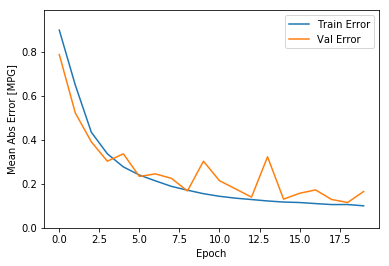

In [68]:
plot_history(history)

In [69]:
pred = model.predict(test_x)

In [70]:
res = pd.concat([pd.DataFrame(pred), pd.DataFrame(test_y)], axis = 1)

In [71]:
res.columns = ["pred_"+x for x in selected_labels] + ["real_"+x for x in selected_labels]

In [72]:
res.sample(frac=1).head(10)

,pred_rage_cat,real_rage_cat
70,-0.638237,1.0
63,-0.973698,1.0
29,-1.009452,1.0
4,-0.989858,1.0
22,-0.992176,1.0
69,-1.051473,1.0
77,-1.109128,1.0
53,-1.001982,1.0
35,-0.998463,1.0
21,-1.003091,1.0


In [73]:
from sklearn.metrics import confusion_matrix

In [81]:
res_labels = res
for emotion_cat in ['rage_cat', 'joy_cat', 'surprise_cat', 'fear_cat', 'sadness_cat']:
    if "pred_"+emotion_cat in res.columns:
        pred = res["pred_"+emotion_cat].values
        real = res["real_"+emotion_cat].values
        
        final_result = []
        pred_binary = []
        for i, pred in enumerate(pred):
            if pred < 0 and real[i] == -1:
                final_result.append(1)
                pred_binary.append(-1)
            elif pred > 0 and real[i] == 1:
                final_result.append(1)
                pred_binary.append(1)
            else:
                final_result.append(0)
                if pred < 0:
                    pred_binary.append(-1)
                else:
                    pred_binary.append(1)
                
        print(emotion_cat, str(round(sum(final_result)/len(final_result)*100, 2)))
        print("(tn,   fp,   fn,   tp)")
        print(confusion_matrix(real, pred_binary).ravel())
        print('----------------')

rage_cat 7.06
(tn,   fp,   fn,   tp)
[ 0  0 79  6]
----------------


In [75]:
# model.save('models/tmp')

In [76]:
# sadness_cat 86.13
# (tn,   fp,   fn,   tp)
# [1085  283   59 1039]

In [77]:
# rage_cat 97.36
# (tn,   fp,   fn,   tp)
# [1562   78    8 1608]

In [78]:
# fear_cat 95.17
# (tn,   fp,   fn,   tp)
# [1464  125   20 1393]

In [79]:
# surprise_cat 87.26
# (tn,   fp,   fn,   tp)
# [1067  221  104 1159]

In [80]:
# joy_cat 92.11
# (tn,   fp,   fn,   tp)
# [1310  205   23 1351]